In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [2]:
def perform_rust_computation(command: str):
    print(f"Command: \"{command}\"")   
    with subprocess.Popen(command, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as stream:
        for line in stream.stdout:
            print(line, end='') 
    
        stdout, stderr = stream.communicate()
        if stream.returncode != 0:
            print(stdout)
            print(stderr)
        else:
            print("=> execution successful.")
    print("")

In [3]:
class RustMonteCarloData:
    def __init__(self, file_name):
        self.file_name = file_name
        self.temperatures       = []
        self.energy_density     = []
        self.magnetisation      = []
        self.specific_heat      = []
        self.mag_susceptibility = []
        self.elapsed_time       = -1
        self.observables        = []
        self.compute_observables()
        
    def to_nd_array(self, name):
        my_lists = getattr(self, name)
        
        if not isinstance(my_lists, np.ndarray):            
            setattr(self, name, np.asarray(my_lists))

    def all_lists_to_array(self):
        for name in vars(self).keys():
            if name != "elapsed_time":
                self.to_nd_array(name)

    def compute_observables(self):
        with open(self.file_name, "r") as file:
            for (n, lines) in enumerate(file):
                if n == 0:
                    slines = lines.split(':')
                    try:
                        self.observables  = slines[0].split(', ')
                        self.elapsed_time = float(slines[1])
                    except Exception as _:
                        self.observables = lines.split(',')
                        print("No elasped time found.")
                else:
                    slines = lines.split(", ")
                    self.temperatures.append(float(slines[0]))
                    self.energy_density.append(float(slines[1]))
                    self.magnetisation.append(float(slines[2]))
                    self.specific_heat.append(float(slines[3]))
                    self.mag_susceptibility.append(float(slines[4]))
        
        self.all_lists_to_array()

## Perform Monte-Carlo calculation:

In [18]:
lengths              = [8, 16, 32]
thermalisation_steps = dict()
measurement_steps    = dict()

for L in lengths:
    if L in (2, 4, 8, 16):
        thermalisation_steps[L] = np.uint(1e5)
        measurement_steps[L]    = np.uint(1e5)
    elif L in (32, 64):
        thermalisation_steps[L] = np.uint(1e5)
        measurement_steps[L]    = np.uint(1e5)

In [19]:
for L in lengths:
    (Lx, Ly)     = (L, L)
    therm_step   = thermalisation_steps[L]
    measure_step = measurement_steps[L]
    
    perform_rust_computation(f"cargo run --release -- {Lx} {Ly} {therm_step} {measure_step}")


Command: "cargo run --release -- 8 8 100000 100000"
Launching for 8x8 with therm steps 100000 & measure_steps: 100000
Time taken: 6s
File saved as results/8x8_from_1.000_to_2.950_with_step_0.050.txt
=> execution successful.

Command: "cargo run --release -- 16 16 100000 100000"
Launching for 16x16 with therm steps 100000 & measure_steps: 100000
Time taken: 33s
File saved as results/16x16_from_1.000_to_2.950_with_step_0.050.txt
=> execution successful.

Command: "cargo run --release -- 32 32 100000 100000"
Launching for 32x32 with therm steps 100000 & measure_steps: 100000
Time taken: 168s
File saved as results/32x32_from_1.000_to_2.950_with_step_0.050.txt
=> execution successful.



In [ ]:
new_L = 64
# lengths.append(new_L)

thermalisation_steps[new_L] = np.uint(1e5)
measurement_steps[new_L]    = np.uint(1e5)

perform_rust_computation(f"cargo run --release -- {new_L} {new_L} {thermalisation_steps[new_L]} {measurement_steps[new_L]}")

Command: "cargo run 64 64 100000 100000 --release"
Launching for 64x64 with therm steps 100000 & measure_steps: 100000


Save the measurements:

In [20]:
results: dict[int, RustMonteCarloData] = dict()

for L in lengths:
    results[L] = RustMonteCarloData(f"results/{L}x{L}_from_1.000_to_2.950_with_step_0.050.txt")
    print(f"elapsed time for size {L}x{L}: {results[L].elapsed_time/60:.3}min ({results[L].elapsed_time}s)")

for res1 in results.values():
    for res2 in results.values():
        if res1 is not res2:
            same_temperatures = np.all(res1.temperatures == res2.temperatures)
            assert(same_temperatures)

temps = results[lengths[0]].temperatures

elapsed time for size 8x8: 0.1min (6.0s)
elapsed time for size 16x16: 0.55min (33.0s)
elapsed time for size 32x32: 2.8min (168.0s)


### Plot!

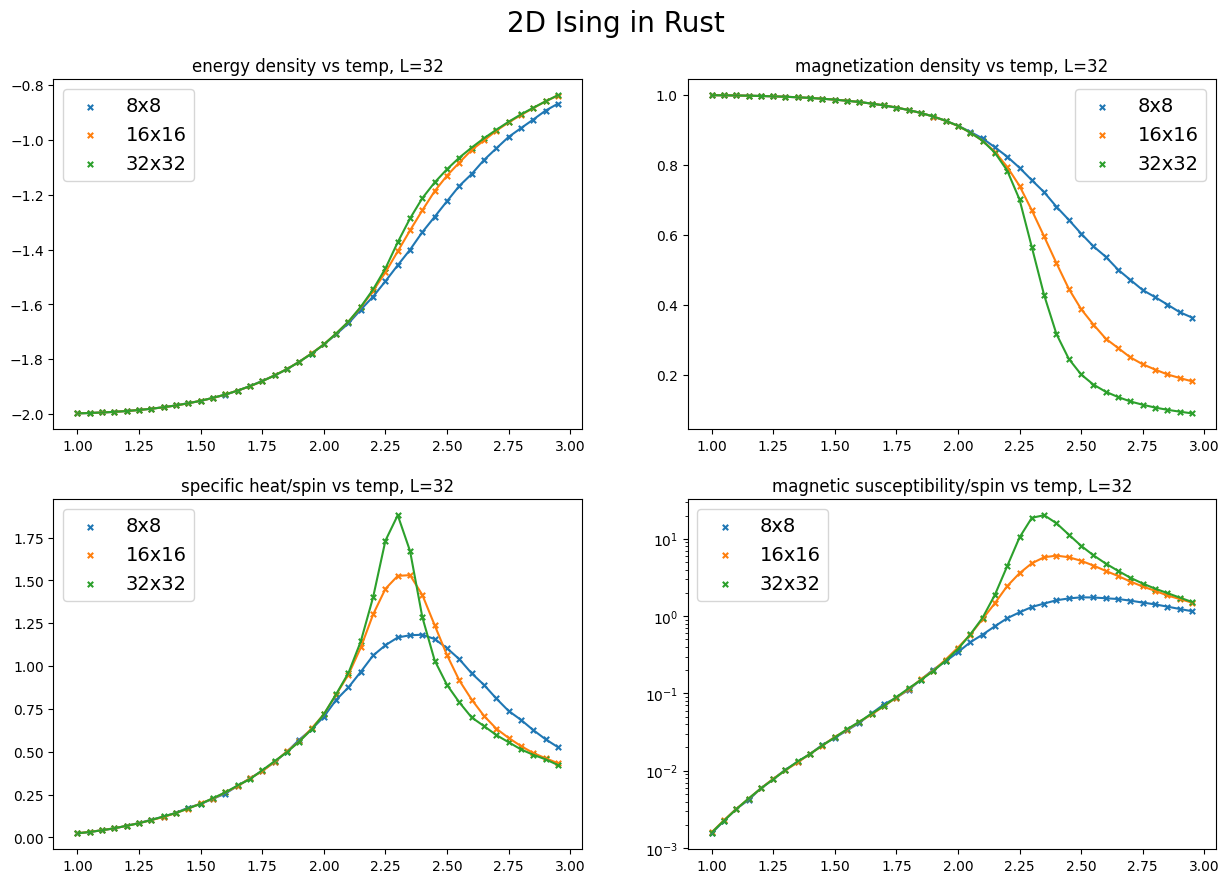

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

fig.suptitle(f"2D Ising in Rust", y=0.95, fontsize=20)
for L in lengths:

    ax1.scatter(temps, results[L].energy_density, s=15, marker= 'x', label=f"{L}x{L}")
    ax1.plot(temps, results[L].energy_density)#, label="Rust" )
    ax1.set_title(f"energy density vs temp, L={L}")
    ax1.legend(loc="upper left",fontsize=14)

    ax2.scatter(temps, results[L].magnetisation, s=15, marker= 'x', label=f"{L}x{L}")
    ax2.plot(temps, results[L].magnetisation)#, label="Rust")
    ax2.set_title(f"magnetization density vs temp, L={L}")
    ax2.legend(loc="upper right",fontsize=14)

    ax3.scatter(temps, results[L].specific_heat, s=15, marker= 'x', label=f"{L}x{L}")
    ax3.plot(temps, results[L].specific_heat)#, label="Rust")
    ax3.set_title(f"specific heat/spin vs temp, L={L}")
    ax3.legend(loc="upper left",fontsize=14)

    ax4.scatter(temps, results[L].mag_susceptibility, s=15, marker= 'x', label=f"{L}x{L}")
    ax4.semilogy(temps, results[L].mag_susceptibility)
    ax4.set_title(f"magnetic susceptibility/spin vs temp, L={L}")
    ax4.legend(loc="upper left",fontsize=14)